In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators for training and validation (image augmentation for training)
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Update with correct paths to your data
train_generator = train_datagen.flow_from_directory(
    r"K:\PROJECT\ORGANISED DATASET\train", 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Binary classification for benign vs malignant
)

test_generator = test_datagen.flow_from_directory(
    r"K:\PROJECT\ORGANISED DATASET\test",  
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Binary classification
)


Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 model with pre-trained ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model initially
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)


In [3]:
# Compile the model with an initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping to monitor validation loss and stop training if overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [5]:
history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=test_generator,
    callbacks=[early_stopping]  # Add early stopping callback
)


Epoch 1/10
194/194 [==============================] - 365s 2s/step - loss: 0.6337 - accuracy: 0.6867 - val_loss: 0.6262 - val_accuracy: 0.6856
Epoch 2/10
194/194 [==============================] - 355s 2s/step - loss: 0.6292 - accuracy: 0.6867 - val_loss: 0.6227 - val_accuracy: 0.6856
Epoch 3/10
194/194 [==============================] - 356s 2s/step - loss: 0.6264 - accuracy: 0.6867 - val_loss: 0.6224 - val_accuracy: 0.6856
Epoch 4/10
194/194 [==============================] - 355s 2s/step - loss: 0.6267 - accuracy: 0.6867 - val_loss: 0.6242 - val_accuracy: 0.6856
Epoch 5/10
194/194 [==============================] - 356s 2s/step - loss: 0.6281 - accuracy: 0.6867 - val_loss: 0.6394 - val_accuracy: 0.6856
Epoch 6/10
194/194 [==============================] - 355s 2s/step - loss: 0.6250 - accuracy: 0.6867 - val_loss: 0.6229 - val_accuracy: 0.6856


In [6]:
# Fine-tuning: Unfreeze the last few layers after initial training
base_model.trainable = True

# Unfreeze the last few layers (you can adjust the number of layers to unfreeze)
for layer in base_model.layers[:-4]:  # Unfreeze the last 4 layers, change this as needed
    layer.trainable = False

# Recompile the model with a higher learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning (unfreezing layers)
history_finetune = model.fit(
    train_generator,
    epochs=10,  
    validation_data=test_generator,
    callbacks=[early_stopping]  # Add early stopping callback again
)


Epoch 1/10
194/194 [==============================] - 374s 2s/step - loss: 0.6348 - accuracy: 0.6797 - val_loss: 0.6374 - val_accuracy: 0.6856
Epoch 2/10
194/194 [==============================] - 365s 2s/step - loss: 0.6303 - accuracy: 0.6854 - val_loss: 0.6449 - val_accuracy: 0.6856
Epoch 3/10
194/194 [==============================] - 365s 2s/step - loss: 0.6272 - accuracy: 0.6847 - val_loss: 0.6241 - val_accuracy: 0.6856
Epoch 4/10
194/194 [==============================] - 363s 2s/step - loss: 0.6292 - accuracy: 0.6855 - val_loss: 0.6225 - val_accuracy: 0.6856
Epoch 5/10
194/194 [==============================] - 364s 2s/step - loss: 0.6254 - accuracy: 0.6863 - val_loss: 0.6207 - val_accuracy: 0.6856
Epoch 6/10
194/194 [==============================] - 363s 2s/step - loss: 0.6251 - accuracy: 0.6857 - val_loss: 0.6210 - val_accuracy: 0.6856
Epoch 7/10
194/194 [==============================] - 364s 2s/step - loss: 0.6248 - accuracy: 0.6863 - val_loss: 0.6280 - val_accuracy: 0.6856

In [7]:
# Save the trained model
model.save(r"C:\Users\K M SASTRY\Desktop\PROJECT\efficientnet_model.h5")
print("Model saved successfully.")

C:\Users\K M SASTRY\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [8]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


54/54 [==============================] - 62s 1s/step - loss: 0.6187 - accuracy: 0.6856
Test accuracy: 68.56%


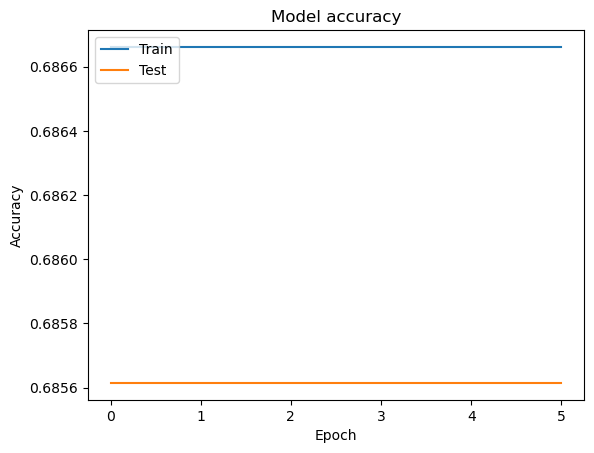

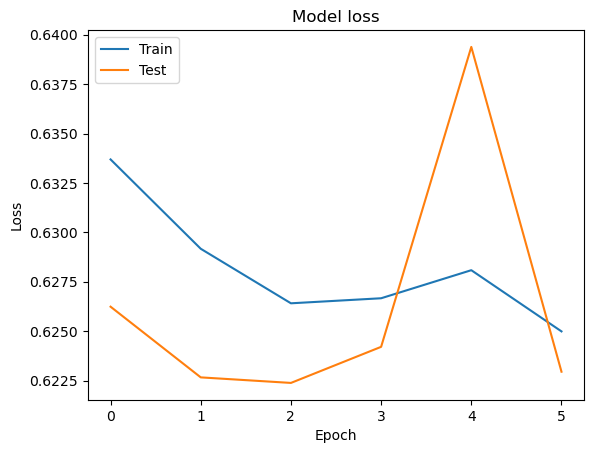

In [10]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
# Load the saved model for predictions
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\efficientnet_model.h5")

# Load and preprocess a new image for prediction
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the image you want to predict
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\ductal_carcinoma\SOB_M_DC_14-2523\40X\SOB_M_DC-14-2523-40-016.png"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to 224x224
img_array = image.img_to_array(img)  # Convert image to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale the image like in training

# Make the prediction
prediction = model.predict(img_array)

# Print the prediction (0 for benign, 1 for malignant)
if prediction[0] > 0.5:
    print("Prediction: Malignant")
else:
    print("Prediction: Benign")


1/1 [==============================] - 2s 2s/step
Prediction: Malignant
